In [9]:
import pandas as pd
import matplotlib.pyplot as plt 
import tqdm
import argparse
import os
import dataclasses
import numpy

from pathlib import Path
from util import FormatWriter

from util import TensorCollectionSuiteSparse, ScipyTensorShifter, \
    ScipyMatrixMarketTensorLoader, SuiteSparseTensor, safeCastScipyTensorToInts, DoublyCompressedMatrix


In [10]:
SS_PATH = os.getenv('SUITESPARSE_PATH')

ssMtx = dataclasses.make_dataclass("SS", [("name", str), ("nnz", int),
                                          ("dim1", int), ("dim2", int),
                                          ("sparsity", float), ("seg_size", int),
                                          ("crd_size", int)])

fiber_data = dataclasses.make_dataclass("FIBER", [("name", str), ("dcsr0", int),
                                          ("dcsr1", [int]), ("dcsc0", int),
                                          ("dcsc1", [int]), ])


In [11]:
print(SS_PATH)

/nobackup/owhsu/sparse-datasets/suitesparse/


In [12]:
# UfuncInputCache attempts to avoid reading the same tensor from disk multiple
# times in a benchmark run.
class UfuncInputCache:
    def __init__(self):
        self.lastLoaded = None
        self.lastName = None
        self.tensor = None
        self.other = None

        self.shifter = ScipyTensorShifter()

    def load(self, tensor, suitesparse, cast):
        if self.lastName == str(tensor):
            return self.tensor, self.other
        else:
            if suitesparse:
                self.lastLoaded = tensor.load(ScipyMatrixMarketTensorLoader())
            else:
                self.lastLoaded = tensor.load()
            self.lastName = str(tensor)
            if cast:
                self.tensor = safeCastScipyTensorToInts(self.lastLoaded)
            else:
                self.tensor = self.lastLoaded

            self.other = self.shifter.shiftLastMode(self.lastLoaded)

            return self.tensor, self.other


inputCache = UfuncInputCache()

In [5]:

def fiber_stats(ss_tensor, tensor_coo, other_coo, show=False):
    print("Getting fiber stats...")
    formatWriter = FormatWriter(True)
    dcsr = formatWriter.convert_format(tensor_coo, "dcsr")
    dcsc = formatWriter.convert_format(tensor_coo, "dcsc")

    fiber_data_list = {}
    fiber_data_list['dcsr0'] = [dcsr.seg0[x + 1] - dcsr.seg0[x] for x in range(len(dcsr.seg0)-1)][0]
    fiber_data_list['dcsr1'] = [dcsr.seg1[x + 1] - dcsr.seg1[x] for x in range(len(dcsr.seg1)-1)]
    fiber_data_list['dcsc0'] = [dcsc.seg0[x + 1] - dcsc.seg0[x] for x in range(len(dcsc.seg0)-1)][0]
    fiber_data_list['dcsc1'] = [dcsc.seg1[x + 1] - dcsc.seg1[x] for x in range(len(dcsc.seg1)-1)]

    if show:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        counter = 0
        for i in range(2):
            for j in range(2):

                ax = axes[i][j]

                # Plot when we have data
                if counter < len(fiber_data_list):

                    key = sorted(list(fiber_data_list.keys()))[counter]
                    ax.hist(fiber_data_list[key], color='blue', alpha=0.5,
                            label='{}'.format(counter))

                # Remove axis when we no longer have data
                else:
                    ax.set_axis_off()

                counter += 1

        plt.show()

    return fiber_data(ss_tensor, **fiber_data_list)

def run_mtx(name):
    filename = name + ".mtx"
    print("Processing %s" % filename)

    ss_tensor = SuiteSparseTensor(os.path.join(SS_PATH, filename))
    tensor_coo, other_coo = inputCache.load(ss_tensor, True, False)

    df = None
    if not isinstance(ss_tensor, numpy.ndarray):
        df = fiber_stats(ss_tensor, tensor_coo, other_coo)
    return df

In [7]:
matrices = ['bcsstm02', 'lp_scsd1']
dfs = pd.DataFrame([run_mtx(x) for x in matrices])
print(dfs)

Processing bcsstm02.mtx
Getting fiber stats...
Processing lp_scsd1.mtx
Getting fiber stats...
       name  dcsr0                                              dcsr1  dcsc0  \
0  bcsstm02     66  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     66   
1  lp_scsd1     77  [24, 20, 24, 20, 24, 20, 24, 20, 24, 20, 24, 2...    760   

                                               dcsc1  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, ...  


<AxesSubplot:>

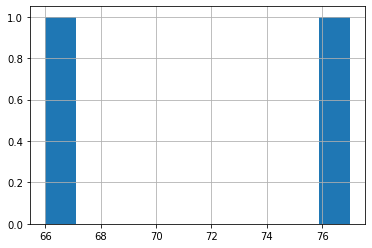

In [8]:
dfs['dcsr0'].hist()


<AxesSubplot:>

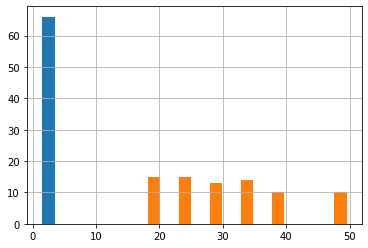

In [9]:
dfs['dcsr1'].hist()

<AxesSubplot:>

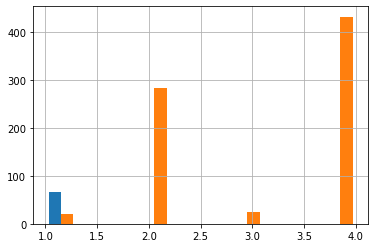

In [10]:
dfs['dcsc1'].hist()

In [11]:
def read_tensor_names(filename):
    result = None
    with open(filename, "r") as f:
        result = f.read().splitlines()
    return result

# Small

In [30]:
small50 = read_tensor_names("suitesparse_valid_small50.txt")
small50_dfs = pd.DataFrame([run_mtx(x) for x in small50])

Processing Trec4.mtx
Getting fiber stats...
Processing rel3.mtx
Getting fiber stats...
Processing relat3.mtx
Getting fiber stats...
Processing cage3.mtx
Getting fiber stats...
Processing Trec5.mtx
Getting fiber stats...
Processing n3c4-b1.mtx
Getting fiber stats...
Processing b1_ss.mtx
Getting fiber stats...
Processing GL7d10.mtx
Getting fiber stats...
Processing cage4.mtx
Getting fiber stats...
Processing ch3-3-b1.mtx
Getting fiber stats...
Processing rel4.mtx
Getting fiber stats...
Processing klein-b1.mtx
Getting fiber stats...
Processing n3c5-b1.mtx
Getting fiber stats...
Processing relat4.mtx
Getting fiber stats...
Processing lpi_itest2.mtx
Getting fiber stats...
Processing Trec6.mtx
Getting fiber stats...
Processing LFAT5.mtx
Getting fiber stats...
Processing Maragal_1.mtx
Getting fiber stats...
Processing n3c4-b4.mtx
Getting fiber stats...
Processing n3c4-b2.mtx
Getting fiber stats...
Processing n3c6-b1.mtx
Getting fiber stats...
Processing n2c6-b1.mtx
Getting fiber stats...
Proc

IG5-6 is 30x77, nnz:251 and Trec4 is 2x3, nnz:3

<AxesSubplot:>

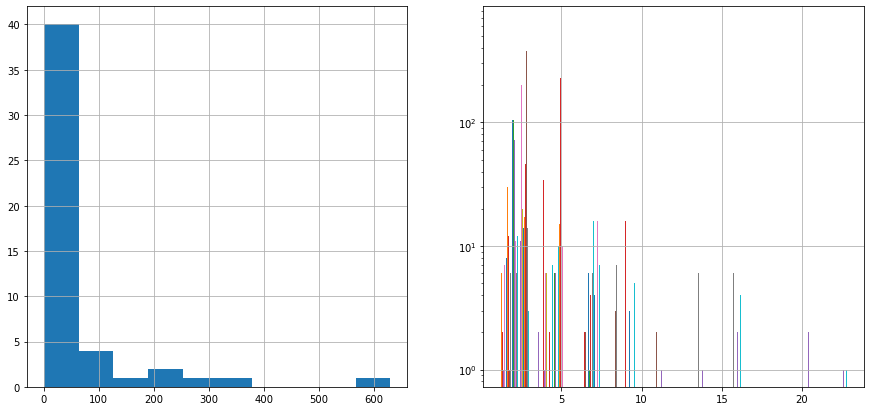

In [49]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')

small50_dfs['dcsr0'].hist(ax=axs[0])
small50_dfs['dcsr1'].hist(ax=axs[1])

<AxesSubplot:>

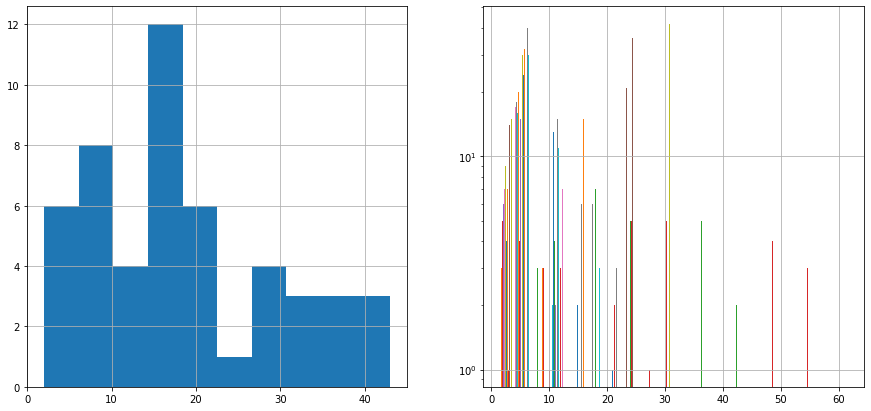

In [50]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')

small50_dfs['dcsc0'].hist(ax=axs[0])
small50_dfs['dcsc1'].hist(ax=axs[1])

# Mid 50

In [31]:
mid50 = read_tensor_names("suitesparse_valid_mid50.txt")
mid50_dfs = pd.DataFrame([run_mtx(x) for x in mid50])

Processing adder_dcop_11.mtx
Getting fiber stats...
Processing adder_dcop_23.mtx
Getting fiber stats...
Processing adder_dcop_54.mtx
Getting fiber stats...
Processing adder_dcop_29.mtx
Getting fiber stats...
Processing adder_dcop_08.mtx
Getting fiber stats...
Processing adder_dcop_02.mtx
Getting fiber stats...
Processing adder_dcop_30.mtx
Getting fiber stats...
Processing adder_dcop_47.mtx
Getting fiber stats...
Processing adder_trans_02.mtx
Getting fiber stats...
Processing adder_trans_01.mtx
Getting fiber stats...
Processing ex3.mtx
Getting fiber stats...
Processing nasa1824.mtx
Getting fiber stats...
Processing spaceShuttleEntry_3.mtx
Getting fiber stats...
Processing watt_2.mtx
Getting fiber stats...
Processing watt_1.mtx
Getting fiber stats...
Processing lp_25fv47.mtx
Getting fiber stats...
Processing rajat12.mtx
Getting fiber stats...
Processing n4c5-b9.mtx
Getting fiber stats...
Processing qiulp.mtx
Getting fiber stats...
Processing progas.mtx
Getting fiber stats...
Processing C

adder_dcop_11 is 1813x1813 nnz: 11,243 and dw1024 is 2048x2048 nnz:10,114

<AxesSubplot:>

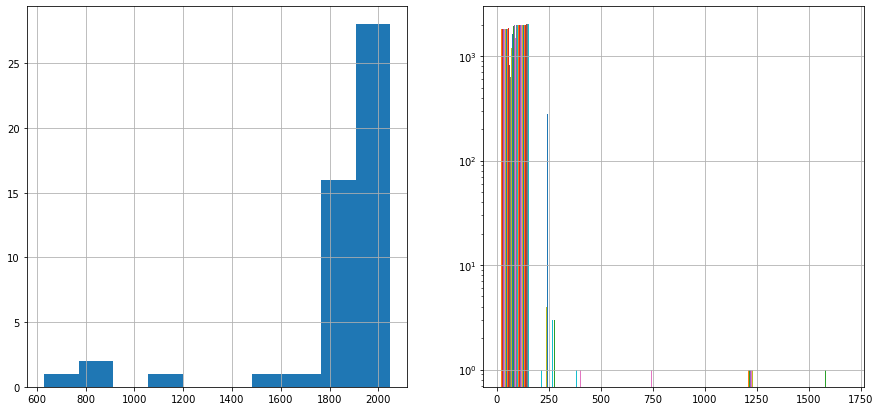

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')


mid50_dfs['dcsr0'].hist(ax=axs[0])
mid50_dfs['dcsr1'].hist(ax=axs[1])

<AxesSubplot:>

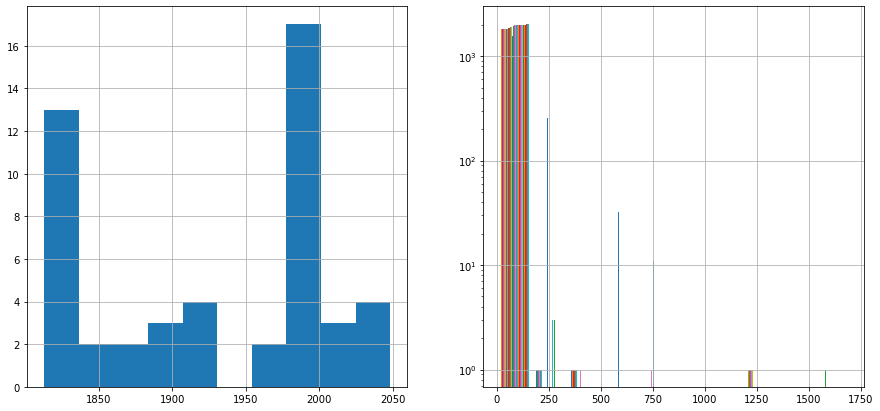

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')


mid50_dfs['dcsc0'].hist(ax=axs[0])
mid50_dfs['dcsc1'].hist(ax=axs[1])

# Large

In [39]:
large50 = read_tensor_names("suitesparse_valid_large50.txt")
large50_dfs = pd.DataFrame([run_mtx(x) for x in large50])

Processing TSOPF_FS_b162_c3.mtx
Getting fiber stats...
Processing testbig.mtx
Getting fiber stats...
Processing c-54.mtx
Getting fiber stats...
Processing helm3d01.mtx
Getting fiber stats...
Processing Goodwin_054.mtx
Getting fiber stats...
Processing vt2010.mtx
Getting fiber stats...
Processing scfxm1-2b.mtx
Getting fiber stats...
Processing car4.mtx
Getting fiber stats...
Processing lpl3.mtx
Getting fiber stats...
Processing sctap1-2b.mtx
Getting fiber stats...
Processing scsd8-2c.mtx
Getting fiber stats...
Processing scsd8-2b.mtx
Getting fiber stats...
Processing south31.mtx
Getting fiber stats...
Processing stormg2-27.mtx
Getting fiber stats...
Processing nsct.mtx
Getting fiber stats...
Processing lp_ken_13.mtx
Getting fiber stats...
Processing route.mtx
Getting fiber stats...
Processing dbir1.mtx
Getting fiber stats...
Processing dbir2.mtx
Getting fiber stats...
Processing ulevimin.mtx
Getting fiber stats...
Processing ts-palko.mtx
Getting fiber stats...
Processing rail516.mtx
Get

In [40]:
from pathlib import Path  
filepath = Path('data/large50_fiber.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
large50_dfs.to_csv(filepath)  

filepath = Path('data/mid50_fiber.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
mid50_dfs.to_csv(filepath)  

filepath = Path('data/small50_fiber.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
small50_dfs.to_csv(filepath)  

In [44]:
filepath = Path('data/small50_fiber.csv')  
small50_dfs_old = pd.read_csv(filepath)

rail4284 is 4,284x1,096,894 nnz:11,284,032 and TSOPF_FS_b162_c3 30,798x30,798 nnz: 1,801,300

<AxesSubplot:>

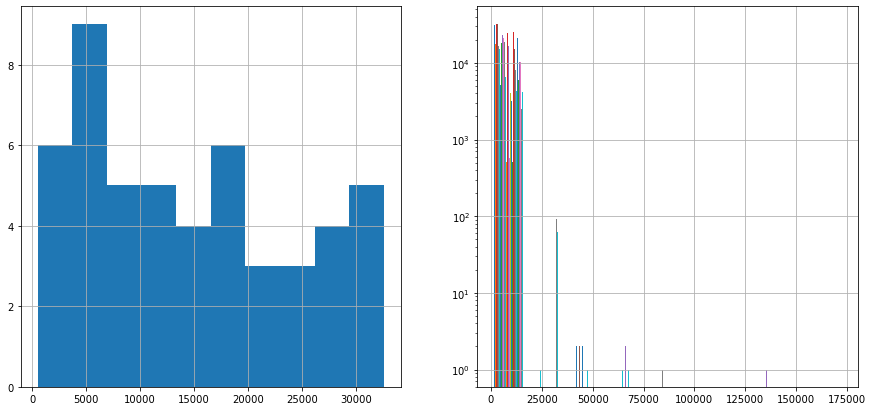

In [41]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')


large50_dfs['dcsr0'].hist(ax=axs[0])
large50_dfs['dcsr1'].hist(ax=axs[1])

<AxesSubplot:>

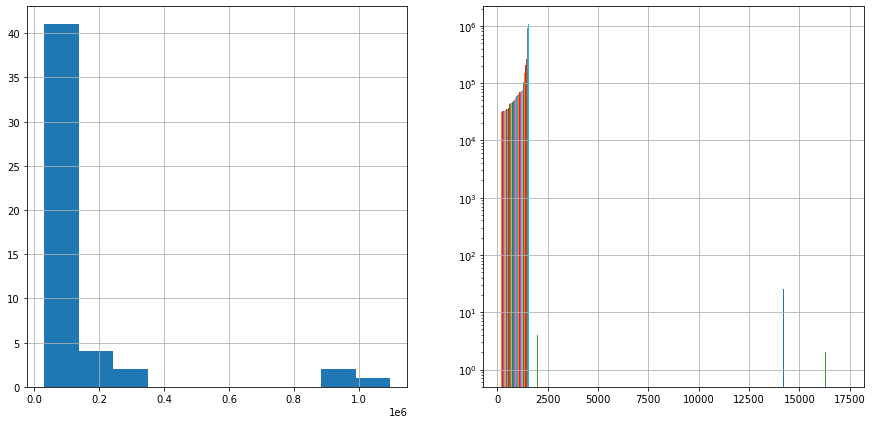

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.yscale('log', nonpositive='clip')


large50_dfs['dcsc0'].hist(ax=axs[0])
large50_dfs['dcsc1'].hist(ax=axs[1])

# Blocking SpMM ijk

In [71]:
# Sizes are in elements. Each element is 2B
def block_spmm_innerprod(b_csf, c_csf, tensor_name, glb_size=131072, memtile_size=1024):
    print("Blocking spmm ijk (inner-prod) for", tensor_name + "...")
    print(b_csf.seg0)
    print(c_csf.seg0)
    
    b_segi = b_csf.seg0
    c_segj = c_csf.seg0
    
    curr_size = 0
    tilei = dict()
    tile_id = 0
    for i in range(len(b_segi)-1):
        fiber_size = b_segi[i+1] - b_segi[i]
        if curr_size + fiber_size > memtile_size:
            tilei[tile_id] = (i, curr_size)
            tile_id += 1
            curr_size = 0
        curr_size += fiber_size
        assert curr_size < memtile_size
    
    curr_size = 0
    tilej = dict()
    tile_id = 0
    for i in range(len(c_segj)-1):
        fiber_size = c_segj[i+1] - c_segj[i]
        if curr_size + fiber_size > memtile_size:
            tilej[tile_id] = (i, curr_size)
            tile_id += 1
            curr_size = 0
        curr_size += fiber_size
        assert curr_size < memtile_size

def get_csf(name):
    filename = name + ".mtx"
    print("Processing %s" % filename)

    ss_tensor = SuiteSparseTensor(os.path.join(SS_PATH, filename))
    tensor_coo, other_coo = inputCache.load(ss_tensor, True, False)

    dcsr = None
    dcsc = None
    result_dict = {}
    if not isinstance(ss_tensor, numpy.ndarray):
        formatWriter = FormatWriter(True)
        dcsr = formatWriter.convert_format(tensor_coo, "dcsr")
        dcsc = formatWriter.convert_format(other_coo, "dcsc")
        result_dict['name'] = name
        result_dict['b'] = dcsr
        result_dict['c'] = dcsc
    return result_dict

In [ ]:

matrices = ['bcsstm02', 'lp_scsd1']
csf_list = [get_csf(x) for x in matrices]

tname = 'bcsstm02'
mat = csf_list[0]
block_spmm_innerprod(mat['b'], mat['c'], tname)

In [159]:
# 
def locate(start, stop, crd, crd_arr):
    return crd_arr[start, stop].find(crd)

# Sizes are in elements. Each element is 2B
def block_vecelemmul(b, c, tensor_name, glb_size=131072, memtile_size=1024):
    print("Blocking vec elemmul for", tensor_name + "...")
    
    b_segi = b["tensor_b_mode_0_seg"]
    c_segi = c["tensor_c_mode_0_seg"]
    b_crdi = b["tensor_b_mode_0_crd"]
    c_crdi = c["tensor_c_mode_0_crd"]
    print(b_segi)
    
    # Block to fit into GLB
    assert b_segi[-1] < glb_size # Ignore for now
    assert c_segi[-1] < glb_size # Ignore for now
    
    over_b = [0]*(len(b_segi) - 1)
    over_c = [0]*(len(c_segi) - 1)
    
    # Block to fit into memtile
    for i in range(len(b_segi)-1):
        fiber_size = b_segi[i+1] - b_segi[i]
        if fiber_size > memtile_size:
            over_b[i] = 1
    for i in range(len(c_segi)-1):
        fiber_size = c_segi[i+1] - c_segi[i]
        if fiber_size > memtile_size:
            over_c[i] = 1
    print(over_b, over_c)

    memtile_tiles = {}
    memtile_tile_id = 0
    for i in range(len(over_b)):
        if over_b[i] or over_c[i]:
            # split b in half in position space (and c follows)
            fiber_size_b = b_segi[i+1] - b_segi[i]
            new_fiber_size_b = floor(fiber_size_b / 2)
            b_segi = b_segi.insert(i, new_fiber_size_b)
            b_coord = b_crdi[new_fiber_size_b]
            new_c = locate(b_coord, c_crdi)
            c_segi = c_segi.insert(i, new_c)
        else:
            memtile_tiles[memtile_tile_id] = (over_b[i], over_c[i])
            memtile_tile_id += 1
            
    print()
#     # Then add sizes
    
#     curr_size = 0
#     memtile_tile_bi = dict()
#     memtile_tile_id = 0
    
#     for i in range(len(b_segi)-1):
#         fiber_size = b_segi[i+1] - b_segi[i]
#         if curr_size + fiber_size > memtile_size:
#             tilei[tile_id] = (i, curr_size)
#             tile_id += 1
#             curr_size = 0
#         curr_size += fiber_size
#         assert curr_size < memtile_size
    
#     curr_size = 0
#     memtile_tile_ci = dict()
#     memtile_tile_id = 0
#     for i in range(len(c_segj)-1):
#         fiber_size = c_segj[i+1] - c_segj[i]
#         if curr_size + fiber_size > memtile_size:
#             tilej[tile_id] = (i, curr_size)
#             tile_id += 1
#             curr_size = 0
#         curr_size += fiber_size
#         assert curr_size < memtile_size
        
#         glb_tile_ci = dict()
#     glb_tile_id = 0

def get_position(crd_arr, crd):
    res = next(i for i, val in enumerate(crd_arr)
                                  if val >= crd)
    print("crd", crd, "res", res, "crd @ pos", crd_arr[res], "crd @ prevpos", crd_arr[res-1])
    return res
    

# Sizes are in elements. Each element is 2B
def block_vecscalarmul(b, tensor_name, glb_size=131072, memtile_size=1024, memtile_crd_space=True):
    print("Blocking vec scalar mul for", tensor_name + "...")
    
    b_shape = b["shape"]
    b_segi = b["tensor_b_mode_0_seg"]
    b_crdi = b["tensor_b_mode_0_crd"]
    print(b_segi)
    
    b_segi_new = []
    
    # Block to fit into GLB
    assert b_segi[-1] < glb_size # Ignore for now
    
    
    # If a fiber is too big, block that fiber into coordinates of 1024...
    
    # Loop through all of the fibers
    for i in range(len(b_segi)-1):
        start_pos = b_segi[i]
        stop_pos = b_segi[i+1]
        last_fiber = stop_pos >= len(b_crdi)
        fiber_size =  stop_pos - start_pos
        
        # If fiber is too large
        if fiber_size > memtile_size:
            if last_fiber:
                fiber = b_crdi[start_pos:]
            else:
                fiber = b_crdi[start_pos: stop_pos]
            
            if memtile_crd_space:
                b_segi_new.append(start_pos)
                print(fiber[0], fiber[-1])
                print(fiber)
                for crd in range(fiber[0]+memtile_size, fiber[-1], memtile_size):
                    pos = start_pos + get_position(fiber, crd)
                    b_segi_new.append(pos)
            else:
                raise NotImplemented
        else: 
            b_segi_new.append(stop_pos)
            
    b_segi_new.append(b_segi[i+1])
    print(b_segi_new)
    b_new = b.copy()
    b_new["tensor_b_mode_0_seg"] = b_segi_new
    return b_new 
    
def get_fiber_sizes(b):
    result = []
    b_shape = b["shape"]
    b_segi = b["tensor_b_mode_0_seg"]
    b_crdi = b["tensor_b_mode_0_crd"]
    
    # Loop through all of the fibers
    for i in range(len(b_segi)-1):
        start_pos = b_segi[i]
        stop_pos = b_segi[i+1]
        last_fiber = stop_pos >= len(b_crdi)
        fiber_size =  stop_pos - start_pos
        result.append(fiber_size)
    return result

In [160]:
from sam.onyx.generate_matrices import MatrixGenerator

In [161]:
b = MatrixGenerator(name="b", shape=[5000], sparsity=0.5, format="CSF")
c = MatrixGenerator(name="c", shape=[5000], sparsity=0.5, format="CSF")
b_arr = b.get_compressed_arrays()
c_arr = c.get_compressed_arrays()



In [162]:
print("sizes", get_fiber_sizes(b_arr))
b_arr_new = block_vecscalarmul(b_arr, "random")
print("new sizes", get_fiber_sizes(b_arr_new))



sizes [2564]
Blocking vec scalar mul for random...
[0, 2564]
1 4997
[1, 3, 4, 5, 6, 7, 8, 11, 13, 16, 24, 25, 28, 29, 30, 39, 45, 46, 48, 49, 52, 55, 56, 59, 61, 62, 64, 68, 69, 70, 71, 72, 75, 77, 78, 80, 86, 89, 90, 91, 92, 97, 100, 105, 107, 108, 110, 115, 116, 117, 118, 121, 124, 126, 129, 130, 131, 132, 134, 137, 140, 143, 144, 145, 147, 148, 149, 151, 153, 155, 157, 160, 161, 163, 165, 168, 173, 181, 182, 183, 184, 188, 190, 192, 193, 196, 197, 198, 200, 204, 206, 208, 210, 211, 215, 216, 219, 220, 222, 223, 226, 231, 232, 233, 236, 237, 240, 242, 243, 246, 247, 248, 249, 252, 253, 255, 258, 259, 260, 261, 263, 265, 266, 267, 268, 270, 271, 272, 273, 275, 276, 277, 278, 280, 281, 283, 286, 287, 288, 289, 290, 295, 296, 297, 298, 301, 302, 304, 305, 306, 308, 310, 311, 312, 313, 314, 315, 320, 322, 324, 328, 329, 332, 333, 336, 338, 339, 341, 345, 346, 347, 349, 357, 358, 359, 360, 365, 368, 369, 371, 372, 373, 375, 381, 383, 384, 385, 387, 389, 390, 391, 392, 393, 394, 395, 396, 